In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
df = pd.read_csv("heart.csv")
print(df.head())
print(df.info())


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5 

In [3]:
X = df.drop("target", axis=1)
y = df["target"]


In [4]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [6]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [8]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [9]:
with open("heart_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("heart_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)




In [10]:
# K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=cv, scoring='accuracy')

print("\n🔁 K-Fold Cross Validation:")
print("Scores for each fold:", cv_scores)
print("Average accuracy across folds:", np.mean(cv_scores))


🔁 K-Fold Cross Validation:
Scores for each fold: [0.64814815 0.8490566  0.8490566  0.83018868 0.8490566 ]
Average accuracy across folds: 0.8051013277428372


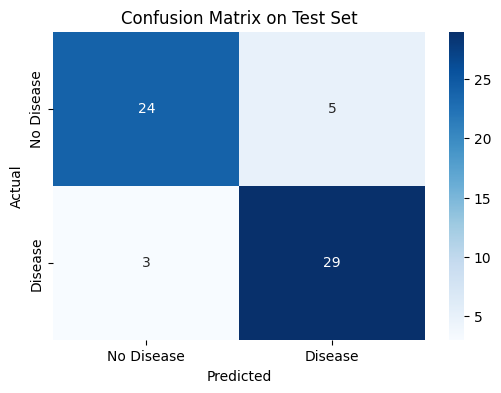

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [12]:
# Three-way decision function
columns = X.columns.tolist()

def predict_with_threshold(model, scaler, input_data):
    input_df = pd.DataFrame([input_data], columns=columns)
    input_scaled = scaler.transform(input_df)
    prob = model.predict_proba(input_scaled)[0][1]

    if prob > 0.55:
        return f"🟢 Positive: The person likely has heart disease (probability: {prob:.4f})"
    elif 0.45 <= prob <= 0.55:
        return f"🟡 Uncertain: Borderline case (probability: {prob:.4f}), further tests advised"
    else:
        return f"🔴 Negative: The person likely does not have heart disease (probability: {prob:.4f})"

In [13]:
# Load model and scaler for test
with open("heart_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("heart_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [14]:
# Example test cases (modify as per your dataset)
positive_input = [63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, 1]
negative_input = [52, 1, 0, 128, 204, 1, 1, 155, 1, 1.2, 1, 0, 2]
uncertain_input = [57, 0, 2, 130, 236, 0, 1, 174, 0, 2.5, 1, 1, 3]

print("\n✅ Positive Case Test:")
print(predict_with_threshold(model, scaler, positive_input))

print("\n✅ Negative Case Test:")
print(predict_with_threshold(model, scaler, negative_input))

print("\n✅ Uncertain Case Test:")
print(predict_with_threshold(model, scaler, uncertain_input))


✅ Positive Case Test:
🟢 Positive: The person likely has heart disease (probability: 0.7400)

✅ Negative Case Test:
🟡 Uncertain: Borderline case (probability: 0.5500), further tests advised

✅ Uncertain Case Test:
🔴 Negative: The person likely does not have heart disease (probability: 0.2200)
